In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
import seaborn as sns
import os
import matplotlib.pyplot as plt
from joblib import dump, load

from gensim.models.word2vec import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

## Divisió dades en conjunt entrenament-conjunt prova

In [2]:
df = pd.read_excel(r'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\data_clean.xlsx', 
                    dtype={'NHC':'string','sentence':'string','label':'int'}) 

In [4]:
pacients_unics = df['NHC'].unique()

pacients_train, pacients_test = train_test_split(pacients_unics, test_size=0.2)

# Filtrem el dataframe original per obtenir els conjunts d'entrenament i prova
df_train = df[df['NHC'].isin(pacients_train)]
df_test = df[df['NHC'].isin(pacients_test)]

# Verifiquem que la proporció d'etiquetes sigui similar en ambdós conjunts
print("Proporció d'etiquetes en conjunt d'entrenamiento:")
print(df_train['label'].value_counts(normalize=True))
print("Total: %d" %df_train.shape[0])

print("\nProporció d'etiquetes en conjunt de prova:")
print(df_test['label'].value_counts(normalize=True))
print("Total: %d" %df_test.shape[0])

Proporció d'etiquetes en conjunt d'entrenamiento:
2    0.641723
0    0.199484
1    0.158793
Name: label, dtype: float64
Total: 5038

Proporció d'etiquetes en conjunt de prova:
2    0.652854
0    0.191556
1    0.155590
Name: label, dtype: float64
Total: 1279


In [5]:
df_train.to_excel(r'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\train.xlsx', index=False)
df_test.to_excel(r'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\test.xlsx', index=False)

## Implementació Word2Vec

In [6]:
df_train = pd.read_excel(r'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\train.xlsx')
df_test = pd.read_excel(r'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\test.xlsx')

X_train, y_train = df_train['sentence'], df_train['label']
X_test, y_test = df_test['sentence'], df_test['label']

Tokenitzem les frases. Cada token correspon a una paraula.

In [7]:
X_train = [f.split() for f in X_train]
X_test = [f.split() for f in X_test]

Emprarem la classe Word2Vec del mòdul gensim.models.word2vec, aquests són els valors predeterminats dels seus paràmetres:

*class gensim.models.word2vec.Word2Vec*(sentences=None, corpus_file=None, vector_size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, epochs=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False, callbacks=(), comment=None, max_final_vocab=None, shrink_windows=True)

### <u>Model CBOW</u>

Inicialitzem i entrenem un primer model simple:

In [26]:
cbow_model1 = Word2Vec(sentences = X_train)

Creem un mètode que donat un model, *model*, i un decimal, *min*, entre 0 i 1 calculi:
1. les similituds cosinus entre tots els parells de paraules del conjunt d'entrenament.
2. filtri les similituds per aquelles que siguin més grans que *min*.
3. escrigui per pantalla el percentatge que representen respecte el total de similituds.

In [10]:
def percentatge_filtre(model, min):

    #llista de parells de paraules
    parells = list(combinations(model.wv.index_to_key,2))

    #llista que conté les similituds cosinus
    cs_cb = [model.wv.similarity(i[0],i[1]) for i in parells]

    #printejem el percentatge de similituds que son més altes de min
    filtre = len(list(filter(lambda x: x>min, cs_cb)))
    total = len(cs_cb)
    print((filtre/total) * 100)

In [28]:
percentatge_filtre(cbow_model1, 0.8)

99.80548895214653


Observem que molt més del 80% de les similituds són superiors a 0.8, per tant el model no representa el nostre corpus correctament. Provem d'augmentar el nombre d'èpoques de la xarxa, però observem que la situació no millora excessivament. 

In [29]:
cbow_model2 = Word2Vec(
    sentences=X_train,
    epochs=10 #nombre d'iteracions de la xarxa sobre el conjunt d'entrenament  
)

percentatge_filtre(cbow_model2, 0.8)

85.55780407001899


A continuació introduïm el paràmetre *sample* i observem que el nombre de similituds cosinus més alts que 0.5 cau fins assolir aproximadament un 0.01% del total.

In [30]:
cbow_model3 = Word2Vec(
    sentences=X_train,
    epochs=10, 
    sample=1e-5 #freqüència amb què s'aplicarà el submostreig de paraules freqüents
)

percentatge_filtre(cbow_model3, 0.5)

0.01084773151490441


### <u>Model Skip-Gram</u>

Inicialitzem i entrenem un primer model simple:

In [31]:
skip_model1 = Word2Vec(sentences=X_train)

percentatge_filtre(skip_model1, 0.8)

99.38192867678872


Observem que sorgeix el mateix problema que abans, més del 80% de similituds són més altes que 0.8. 
Després d'experimentar amb diversos valors dels paràmetres *vector_size*, *epochs*, *window*, *alpha* i *negative*, trobem els que semblen ser més adients pel nostre problema. Posteriorment veurem per què.

In [8]:
skip_model2 = Word2Vec(
    sentences=X_train, 
    vector_size=70, #dimensió de l'espai embedding
    epochs=6, 
    window=2, #mida de la finestra del context de cada paraula
    alpha=0.01, #learning rate inicial
    sg=1, #skip-gram
    negative=2, #quantitat de paraules negatives que es mostregen durant l'entrenament
    compute_loss=True #aquest paràmetre ens permet posteriorment calcular el valor final de la funció de pèrdua
)

In [11]:
percentatge_filtre(skip_model2, 0.8)

10.52904370912291


El fet que un 13% de les similituds siguin més altes de 0.8 sembla ser un valor raonable i lògic. A continuació agrupem les similituds cosinus en intervals de llargada 0.2 i creem un diagrama de barres verticals que mostri la quantitat que hi ha en cada grup. Observem que aquestes segueixen aproximadament una distribució normal.

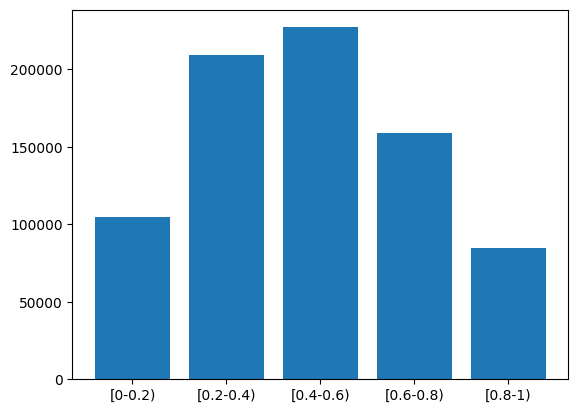

In [12]:
cs = [skip_model2.wv.similarity(i[0],i[1]) for i in list(combinations(skip_model2.wv.index_to_key,2))]
iter = np.array([(0,0.2),(0.2,0.4),(0.4,0.6),(0.6,0.8),(0.8,1)])
y = []

for (i,j) in iter: y.append(len(list(filter(lambda x: x>=i and x<j, cs))))

fig, ax = plt.subplots()
ax.bar(['[0-0.2)','[0.2-0.4)','[0.4-0.6)','[0.6-0.8)','[0.8-1)'], y)
plt.show()

Mantenint els valors de *vector_size*, *window*, *alpha* i *negative* hem observat que augmentant el nombre d'èpoques amb el paràmetre *epochs* el nombre de similituds cosinus dins de l'interval [0.8-1) creix. És a dir, el model troba més similituds entre paraules com més iteracions realitzi la xarxa sobre les dades, aquest podria ser un signe de sobreajustament. 

In [13]:
fig.savefig(r'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\imagenes\similituds.jpg')

Per últim visualitzem algunes similituds cosinus que el model ha capturat correctament:

In [14]:
print("(suggestiva, suggestives) -> %.5f" %skip_model2.wv.similarity('suggestiva','suggestives'))
print("(folfiri, folfox) -> %.5f" %skip_model2.wv.similarity('folfiri','folfox'))
print("(adk, adenocarcinoma) -> %.5f" %skip_model2.wv.similarity('adk','adenocarcinoma'))
print("(eco, ecografia) -> %.5f" %skip_model2.wv.similarity('eco','ecografia'))
print("(evidencia, signes) -> %.5f" %skip_model2.wv.similarity('evidencia','signes'))
print("(hepatiques, hepatica) -> %.5f" %skip_model2.wv.similarity('hepatiques','hepatica'))
print("(hepatica, hep) -> %.5f" %skip_model2.wv.similarity('hepatica','hep'))
print("(adenocarcinoma, tumor) -> %.5f" %skip_model2.wv.similarity('adenocarcinoma','tumor'))
print("(loes, imatges) -> %.5f" %skip_model2.wv.similarity('loes','imatges'))
print("(suggestives, sospitoses) -> %.5f" %skip_model2.wv.similarity('suggestives','sospitoses'))
print("(suggestives, compatibles) -> %.5f" %skip_model2.wv.similarity('suggestives','compatibles'))
print("(sospitoses, compatibles) -> %.5f" %skip_model2.wv.similarity('sospitoses','compatibles'))
print("(recaiguda, recidiva) -> %.5f" %skip_model2.wv.similarity('recaiguda','recidiva'))
print("(inici, inicia) -> %.5f" %skip_model2.wv.similarity('inici','inicia'))

(suggestiva, suggestives) -> 0.82815
(folfiri, folfox) -> 0.92513
(adk, adenocarcinoma) -> 0.96838
(eco, ecografia) -> 0.92999
(evidencia, signes) -> 0.94362
(hepatiques, hepatica) -> 0.97895
(hepatica, hep) -> 0.98086
(adenocarcinoma, tumor) -> 0.88794
(loes, imatges) -> 0.64522
(suggestives, sospitoses) -> 0.93820
(suggestives, compatibles) -> 0.77313
(sospitoses, compatibles) -> 0.89070
(recaiguda, recidiva) -> 0.82722
(inici, inicia) -> 0.87153


Guardem els word embeddings.

In [15]:
word_vectors = skip_model2.wv
word_vectors.save(r'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\skipgram.wordvectors')

In [16]:
wv = KeyedVectors.load(r'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\skipgram.wordvectors', mmap='r')

Definim un mètode que donat una llista de vectors de dimensió 100, retorna el vector resultat de fer la mitjana aritmètica d'aquests.

In [42]:
def from_tokens_to_wv_mean(row):
    
    vectors = [wv[word] for word in row if word in wv.index_to_key]

    if vectors:
        return np.mean(vectors, axis=0)
    else: 
        return np.zeros(100)

L'apliquem sobre les nostres frases per obtenir els word embeddings i els normalitzem abans de ser processats pels classificadors.

In [43]:
X_train = list(map(lambda row: from_tokens_to_wv_mean(row), X_train))
X_test = list(map(lambda row: from_tokens_to_wv_mean(row), X_test))

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Implementació classificadors SVM

### Definició mètodes generals

1 -- Mètode que donats un conjunt d'etiquetes reals *y* i les seves prediccions *y_pred* calcula l'exactitud i la puntuació F1 amb mitjana ponderada. L'utilitzarem després d'entrenar els classificadors amb els seus paràmetres òptims per tal de visualitzar el seu rendiment envers el conjunt d'entrenament i el conjunt de prova.

In [44]:
def scores(y, y_pred):

    print("exactitud -> %.3f, puntuació F1 -> %.3f" %(accuracy_score(y, y_pred), f1_score(y, y_pred, average='weighted')))

2 -- Mètode que visualitza i guarda tres gràfics de densitat de nucli dels valors obtinguts al aplicar les tres funcions de decisió generades pels tres classificadors.

In [56]:
def kernel_density_estimate(X, y_pred, model, kernel):

    proj_0 = pd.DataFrame(data=[(model.estimators_[0].decision_function(X[i].reshape(1, -1)), y_pred[i]) for i in range(len(X))], columns=['proj','classe'])
    proj_1 = pd.DataFrame(data=[(model.estimators_[1].decision_function(X[i].reshape(1, -1)), y_pred[i]) for i in range(len(X))], columns=['proj','classe'])
    proj_2 = pd.DataFrame(data=[(model.estimators_[2].decision_function(X[i].reshape(1, -1)), y_pred[i]) for i in range(len(X))], columns=['proj','classe'])

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    sns.kdeplot(proj_0.loc[proj_0['classe']==0, 'proj'].apply(lambda x: x[0]), ax = axs[0], multiple="stack")
    sns.kdeplot(proj_0.loc[proj_0['classe'].isin([1,2]), 'proj'].apply(lambda x: x[0]), ax = axs[0], multiple="stack")
    axs[0].axvline(x=0, linestyle='--', color='black')
    axs[0].set_ylabel('Densitat')
    axs[0].set_xlabel('')
    axs[0].legend(['Classe 0', 'Resta classes'], loc='upper left')

    sns.kdeplot(proj_1.loc[proj_1['classe']==1, 'proj'].apply(lambda x: x[0]), ax = axs[1], multiple="stack")
    sns.kdeplot(proj_1.loc[proj_1['classe'].isin([0,2]), 'proj'].apply(lambda x: x[0]), ax=axs[1], multiple="stack")
    axs[1].axvline(x=0, linestyle='--', color='black')
    axs[1].set_ylabel('')
    axs[1].set_xlabel('')
    axs[1].legend(['Classe 1', 'Resta classes'], loc='upper left')

    sns.kdeplot(proj_2.loc[proj_2['classe']==2, 'proj'].apply(lambda x: x[0]), ax = axs[2], multiple="stack")
    sns.kdeplot(proj_2.loc[proj_2['classe'].isin([0,1]), 'proj'].apply(lambda x: x[0]), ax = axs[2], multiple="stack")
    axs[2].axvline(x=0, linestyle='--', color='black')
    axs[2].set_ylabel('')
    axs[2].set_xlabel('')
    axs[2].legend(['Classe 2', 'Resta classes'], loc='upper left')

    fig.savefig(os.path.join(r"C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\imagenes", kernel + ".png"))

La cerca dels paràmetres adients per cada classificador es duu a terme mitjançant la classe *GridSearchCV*. Aquest pren un estimador, un conjunt de paràmetres i una mètrica d'èxit i avalua per quins paràmetres l'estimador obté un millor valor de la mètrica.

### <u>Nucli lineal</u>

In [46]:
model = OneVsRestClassifier(SVC(kernel='linear', class_weight='balanced', probability=True), n_jobs=3)

param = {'estimator__C': [0.001, 0.01, 0.1, 10, 50, 100]} 

clf = GridSearchCV(estimator = model, param_grid=param, scoring='roc_auc_ovr', refit=True, n_jobs=4)
clf.fit(X_train, y_train)

model = clf.best_estimator_
print(clf.best_params_)

{'estimator__C': 0.1}


Cal recalcar que la classe *OneVsRestClassifier* entrena el model que rep mitjançant l'estratègia One vs Rest o One vs All, la qual consisteix en dividir el problema de multiclassificació amb m classes en els subproblemes de classificació binaria:

<center>
classe i vs resta de classes, per i=1,...,m.
</center>

L'ús d'aquesta classe és degut a què per defecte la classe sklearn.svm.SVC aplica l'estratègia One vs One ja que els algoritmes de SVM no escalen bé treballant amb tot el conjunt d'entrenament, en canvi, amb aquesta estratègia cada classificador només s'entrena amb la part del conjunt d'entrenament que correspon a les classes que ha de distingir. Tot i així per  

In [58]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("Conjunt entrenament :")
scores(y_train, y_train_pred)
print("Conjunt prova :")
scores(y_test, y_test_pred)

Conjunt entrenament :
exactitud -> 0.775, puntuació F1 -> 0.784
Conjunt prova :
exactitud -> 0.754, puntuació F1 -> 0.763


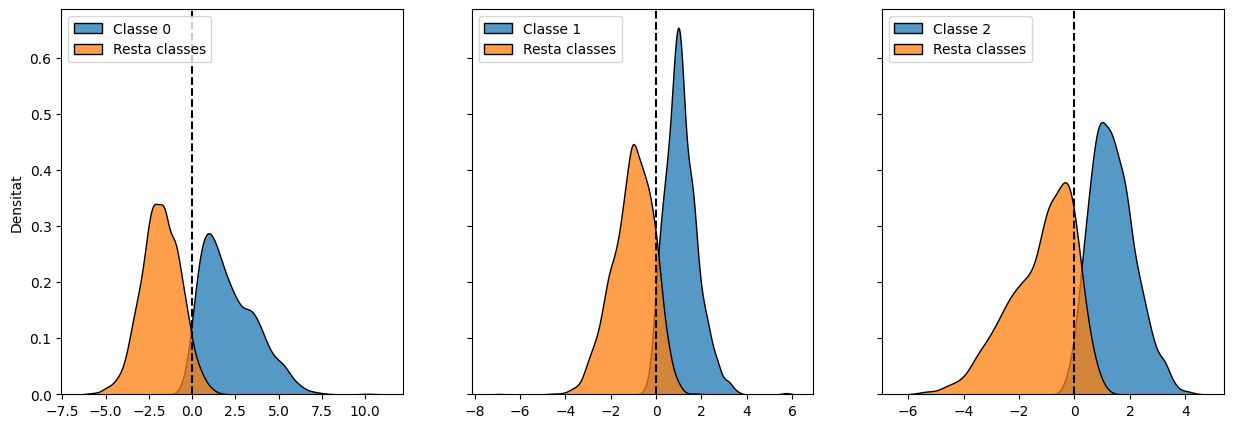

In [59]:
kernel_density_estimate(X_train, y_train_pred, model, 'lineal')

Guardem el model.

In [ ]:
dump(model, 'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\linear.joblib')

### <u>Nucli polinòmic</u>

In [53]:
model2 = OneVsRestClassifier(SVC(kernel='poly', class_weight='balanced', probability=True), n_jobs=3)

param = {'estimator__C': [0.001, 0.01, 0.1, 10, 50, 100], 
         'estimator__degree': [3, 5, 7, 10], 
         'estimator__coef0': [0.1, 1, 5, 10],
        }

clf2 = GridSearchCV(estimator = model2, param_grid=param, scoring='roc_auc_ovr', refit=True, n_jobs=4)
clf2.fit(X_train, y_train)

model2 = clf2.best_estimator_
print(clf2.best_params_)

{'estimator__C': 0.1, 'estimator__coef0': 5, 'estimator__degree': 3}


In [54]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

print("Conjunt entrenament :")
scores(y_train, y_train_pred)
print("Conjunt prova :")                                        
scores(y_test, y_test_pred)

Conjunt entrenament :
exactitud -> 0.827, puntuació F1 -> 0.834
Conjunt prova :
exactitud -> 0.781, puntuació F1 -> 0.788


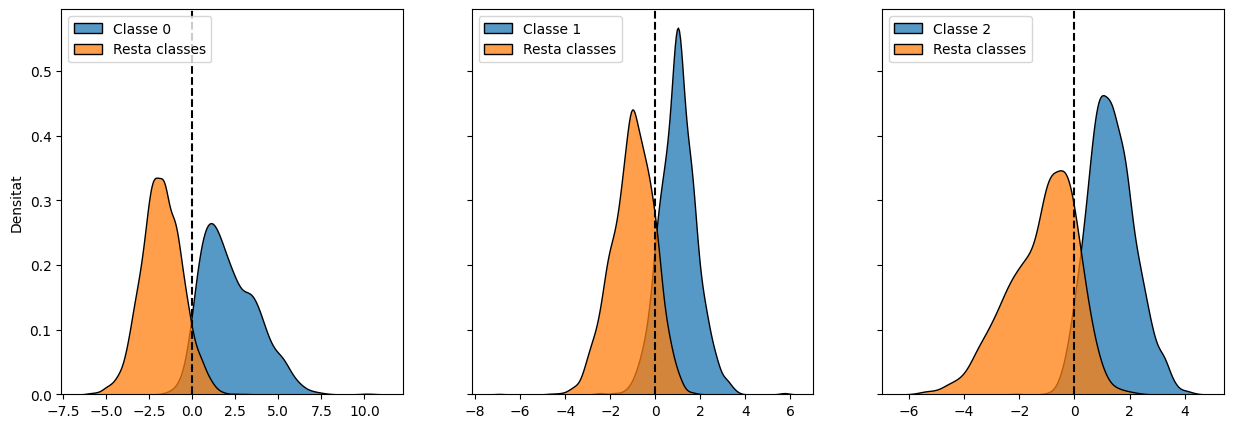

In [57]:
kernel_density_estimate(X_train, y_train_pred, model, 'polinomic')

Guardem el model.

In [ ]:
dump(model, 'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\polynomial.joblib')

### <u>Nucli gaussià</u>

In [ ]:
model3 = SVC(kernel='rbf', class_weight='balanced', probability=True)

param = {'C': [0.001, 0.01, 0.1, 10, 50, 100], 
         'gamma': ['auto', 1, 0.1, 0.01, 0.001]
        }

clf3 = GridSearchCV(estimator = model3, param_grid=param, scoring='roc_auc_ovr', refit=True, n_jobs=4)
clf3.fit(X_train, y_train)

model3 = clf3.best_estimator_
print(clf3.best_params_)

In [ ]:
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

print("Conjunt entrenament :")
scores(y_train, y_train_pred)
print("Conjunt prova :")
scores(y_test, y_test_pred)

In [ ]:
kernel_density_estimate(X_train, y_train_pred, model, 'gaussia')

Guardem el model.

In [ ]:
dump(model, 'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\gaussia.joblib')

### <u>Nucli sigmoide</u>

In [ ]:
model4 = SVC(kernel='sigmoid', class_weight='balanced', probability=True)

param = {'C': [0.001, 0.01, 0.1, 10, 50, 100], 
         'coef0': [0.1, 1, 5, 10],
         'gamma': ['auto', 1, 0.1, 0.01, 0.001]
        }

clf4 = GridSearchCV(estimator = model4, param_grid=param, scoring='roc_auc_ovo', refit=True, n_jobs=4)
clf4.fit(X_train, y_train)

model4 = clf4.best_estimator_
print(clf4.best_params_)

In [ ]:
y_train_pred = model4.predict(X_train)
y_test_pred = model4.predict(X_test)

print("Conjunt entrenament :")
scores(y_train, y_train_pred)
print("Conjunt prova :")
scores(y_test, y_test_pred)

In [ ]:
kernel_density_estimate(X_train, y_train_pred, model, 'sigmoide')

Guardem el model.

In [ ]:
dump(model, 'C:\Users\jblan\OneDrive\Documentos\ELENA\TFG\sigmoide.joblib')